In [3]:
import requests, json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

import scipy
from scipy import *
import os
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cross_validation import train_test_split

sns.set_context("talk", font_scale=1.3)

ben_style = {'axes.axisbelow': True,
 'axes.edgecolor': '0',
 'axes.facecolor': 'white',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.linewidth': 1,
 'figure.facecolor': 'white',
 'font.family': [u'sans-serif'],
             'font.size': 75,
 'font.sans-serif': [u'Helvetica Neue',
  u'Liberation Sans',
  u'Bitstream Vera Sans',
  u'sans-serif'],
 'grid.color': '0.9',
 'grid.linestyle': u'',
 'image.cmap': u'Greys',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': u'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': u'in',
 'xtick.major.size': 3.0,
 'xtick.minor.size': 2.0,
 'ytick.color': '.15',
 'ytick.direction': u'in',
 'ytick.major.size': 3.0,
 'ytick.minor.size': 2.0}

sns.set_style("white", ben_style)


service_location = "http://localhost:3000"


def get_collection_member(id=None, **kw):
    global service_location
    
    if id is None:
        return
    return requests.get(service_location+'/collection/%s/member'%(id))

def get_ko(id="", query=""):
    global service_location
    query_string = ""
    
    if not id and not query:
        return
    if query:
        query_string = "?where=%s"%(json.dumps(query))
    
    return requests.get(service_location+'/ko/%s%s'%(id, query_string))

def query_ko(query):
    print json.dumps(query)
    return requests.get(service_location+'/ko/?where=%s'%(json.dumps(query)))


def create_ko(ko):
    return requests.post(service_location+'/ko', json = ko)


In [4]:
r = get_ko(query={"owner":"blaiszik"})
r.url

u'http://localhost:3000/ko/?where=%7B%22owner%22:%20%22blaiszik%22%7D'

In [ ]:
r.json()

# Create a test Dataset

In [6]:
# Blobs with 4 -- slight overlaps
x,y = make_blobs(n_samples=1000, centers=10, cluster_std=0.8)
dataset = {"x":x.tolist(), "y":y.tolist()}

# Create ko

In [7]:
print "Creating"
sample_ko = {"owner":"blaiszik","key":"test","object":"python","uri":["http://google.com"], 
             "data":dataset }
r = create_ko(sample_ko)
result = r.json()
new_id =  result['_id']

Creating


# Get ko By ID

In [8]:
r = get_ko(new_id)
result =  r.json()

df1 = pd.DataFrame(result['data']['x'], columns=["x1","x2"])
df2 = pd.DataFrame(result['data']['y'], columns=["y"])
df = pd.concat([df1,df2], axis=1)

# data = result['data']
# headers = data.pop(0)
# df = pd.DataFrame(data, columns=headers)

/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


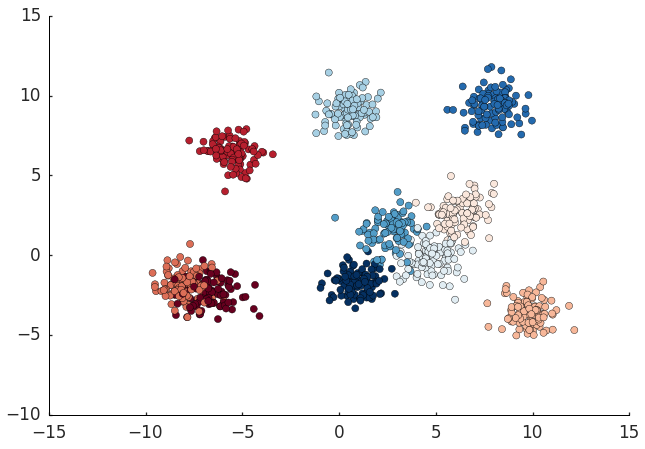

In [9]:
plt.scatter(df['x1'], df['x2'], c=df['y'], s=50, cmap=plt.cm.RdBu_r);
sns.despine()

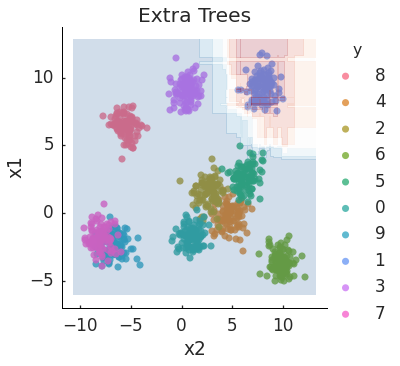

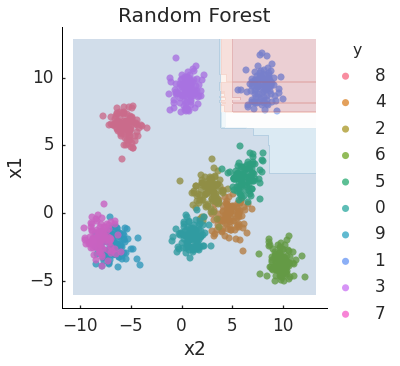

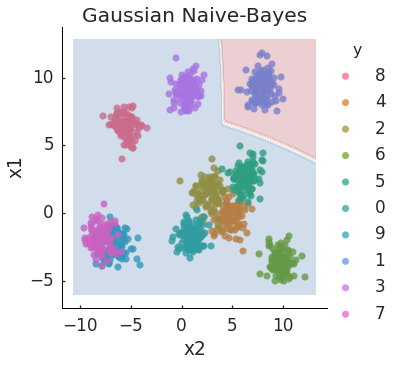

In [10]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC # "Support Vector Classifier"

clfs = [ 
        (ExtraTreesClassifier(n_estimators=10), "Extra Trees"),
        (RandomForestClassifier(n_estimators=10), "Random Forest"),
        (GaussianNB(), "Gaussian Naive-Bayes")
        ]

for i, (clf,title) in enumerate(clfs):
    clf.fit(df[['x1','x2']], df['y'])
    fig  = sns.lmplot(x="x1", y="x2", data=df, order=1, hue="y", fit_reg=False, scatter_kws={"s": 50});
    fig.ax.set_ylabel('x1')
    fig.ax.set_xlabel('x2')
    fig.ax.set_title(title)
    
    ## Plot decision contour or probability function
    h = .01  # step size in the mesh
    x_min, x_max = df['x1'].min() - 1, df['x1'].max() + 1
    y_min, y_max = df['x2'].min() - 1, df['x2'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                              np.arange(y_min, y_max, h))
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    fig.ax.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.RdBu_r)

# KMeans Clustering

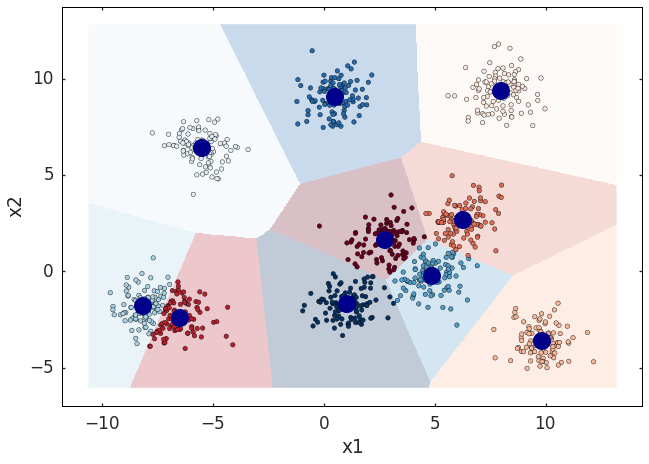

In [11]:
from sklearn.cluster import KMeans
show_decision = True
show_centroids = True
kmeans = KMeans(n_clusters=10)
y_pred = kmeans.fit_predict(df[['x1','x2']])

##Decision Boundary
if show_decision:
    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = df['x1'].min() - 1, df['x1'].max() + 1
    y_min, y_max = df['x2'].min() - 1, df['x2'].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()

    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.RdBu_r,
               aspect='auto', origin='lower', alpha=0.25, zorder=0)
    ###


plt.scatter(df['x1'],df['x2'], c=y_pred, cmap=plt.cm.RdBu_r, zorder=1)
ax = plt.gca()
ax.set_xlabel('x1')
ax.set_ylabel('x2')



if show_centroids:
    # Plot the centroids as a green  X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=100, linewidths=8,
                color='darkblue', zorder=2)